In [1]:
import os
import sys
libdir = os.path.dirname('/usr/people/muntjewe/git/laura_scripts/')
sys.path.insert(0, libdir) 


from libpyvarex import libplot
from libpyvarex import libtimeseries

In [2]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Name some Cartopy projections for ease of use\n",
myproj = ccrs.PlateCarree()

In [3]:
import cartopy.feature as cf

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import cmocean.cm as cmo
from matplotlib import cm

In [6]:
import numpy as np
import xarray as xr

In [7]:
## figure location
fig_directory='/usr/people/muntjewe/LENTIS/figs/datapaper/'


### Open the data from LENTIS and from ERA5 

In [8]:
ds_tas=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Amon/tas/tas*.nc',combine='nested',concat_dim='ens')
tas=ds_tas['tas']

In [9]:
ls /net/pc200021/nobackup_1/users/muntjewe/LENTIS/lproc/ERA/

era5_t2m_1990001-201912.nc
era5_t2m_1991001-202012.nc
era5_t2m_ECE3grid_1990001-201912.nc
era5_t2m_ECE3grid_1991001-202012.nc
era5_t2m_ECE3grid_tunits-days_1990001-201912.nc
era5_t2m_ECE3grid_tunits-days_1991001-202012.nc


In [9]:
ds_ERA=xr.open_dataset('/net/pc200021/nobackup_1/users/muntjewe/LENTIS/lproc/ERA/era5_t2m_ECE3grid_1991001-202012.nc',decode_times=False)
units, reference_date = ds_ERA.time.attrs['units'].split('since')
ds_ERA['time'] = pd.date_range(start=reference_date, periods=ds_ERA.sizes['time'], freq='MS')

tasERA=ds_ERA['t2m']

In [10]:

# make 2D annual mean tas from LENTIS

tas_lentis_ANN = []


for i in np.arange(1,16+1):
    for j in np.arange(0,9+1):
        # open the dataset
        print('working on: '+str(i).zfill(2)+str(j))
        ds=xr.open_dataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Amon/tas/tas_h'+str(i).zfill(2)+str(j)+'.nc')
        annual_mean = ds['tas'].groupby('time.year').mean('time')
        tas_lentis_ANN.append(annual_mean)
        ds.close()


working on: 010
working on: 011
working on: 012
working on: 013
working on: 014
working on: 015
working on: 016
working on: 017
working on: 018
working on: 019
working on: 020
working on: 021
working on: 022
working on: 023
working on: 024
working on: 025
working on: 026
working on: 027
working on: 028
working on: 029
working on: 030
working on: 031
working on: 032
working on: 033
working on: 034
working on: 035
working on: 036
working on: 037
working on: 038
working on: 039
working on: 040
working on: 041
working on: 042
working on: 043
working on: 044
working on: 045
working on: 046
working on: 047
working on: 048
working on: 049
working on: 050
working on: 051
working on: 052
working on: 053
working on: 054
working on: 055
working on: 056
working on: 057
working on: 058
working on: 059
working on: 060
working on: 061
working on: 062
working on: 063
working on: 064
working on: 065
working on: 066
working on: 067
working on: 068
working on: 069
working on: 070
working on: 071
working 

In [11]:
#np.asarray(tas_lentis_ANN)

tas_lentis_ANN_xr = xr.DataArray(np.asarray(tas_lentis_ANN), 
coords={'ens': np.arange(1,160+1), 'year': np.arange(2000,2009+1),'lat': tasERA['lat'],'lon': tasERA['lon']}, 
dims=["ens", "year", "lat", "lon"])


In [12]:
new_arr = tas_lentis_ANN_xr.stack(years=['ens','year'])

### Do some basic statistics, mean

To calculate the absolute bias

In [13]:
mean_era = tasERA.mean(dim='time')
mean_lentis = new_arr.mean(dim='years')
anom = mean_lentis - mean_era

In [14]:
mean_lentis = new_arr.mean(dim='years')

In [15]:
anom = mean_lentis - mean_era

### Calculate the significance of the bias

Do standard t-test on the distributions per grid cell of 10-year ERA data and 1600 year LENTIS data

In [16]:
ann_mean_era = tasERA.groupby('time.year').mean(dim='time')

In [17]:
ann_mean_lentis = new_arr.transpose('years', 'lat', 'lon')
#tas

In [18]:
from scipy.stats import ttest_rel


In [19]:
from scipy.stats import ttest_ind

In [20]:
statres, pval = ttest_ind(ann_mean_era, ann_mean_lentis,axis=0)

In [21]:
nosig_area   = np.where(pval > 0.05)
lons, lats = np.meshgrid(anom.lon, anom.lat)

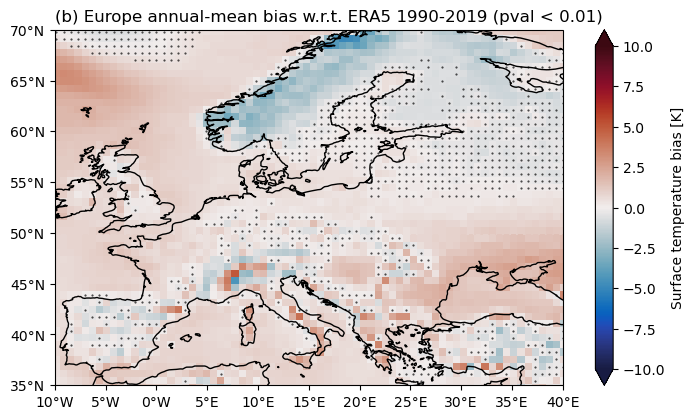

In [67]:
plotdir="/usr/people/muntjewe/papers/data_paper/"

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(2, 1 )#, figure=fig,height_ratios=[2, 1])
#fig = plt.figure(figsize=(14,5))
#gs = gridspec.GridSpec(1, 2, figure=fig) #,width_ratios=[3, 1])
#cmap = cm.seismic 
cmap = cmo.balance

vmin1=-10
vmax1=10

#gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 3.2])



# ============================  fig 1

# ax1 = libplot.define_global_map(fig,sps=gs[0,0])
# cl = anom.plot.imshow(robust=True, ax=ax1, add_colorbar=True, extend='both',vmin=vmin1, vmax=vmax1, cmap=cmap) #, levels=21)
# #_ = ax1.scatter(lons[nosig_area][::12], lats[nosig_area][::12], marker = '.', s = 0.5, c = 'k', alpha = 0.6, transform = myproj) # 
# cl.colorbar.set_label('Surface temperature bias [K]')

# #prc_corr.plot(ax=a1, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
# #_ = ax1.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

# ax1.set_title('')
# ax1.set_title('(a) Global annual-mean bias w.r.t. ERA5 1990-2019 (pval < 0.01) ',loc='left',fontsize=12)

# ============================  fig 2

ax2 = libplot.define_europe_map(fig,sps=gs[1,0])
cr = anom.plot.imshow(robust=True, ax=ax2, transform=myproj,  extend='both', add_colorbar=True,vmin=vmin1, vmax=vmax1, cmap=cmap ) #, levels=21)
_ = ax2.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)

cr.colorbar.set_label('Surface temperature bias [K]')
ax2.set_ylabel('')
ax2.set_xlabel('')

ax2.set_title('')
ax2.set_title('(b) Europe annual-mean bias w.r.t. ERA5 1990-2019 (pval < 0.01)  ',loc='left',fontsize=12)




plt.tight_layout()

#plt.savefig(plotdir+"fig_datadescr_biasERA_1990-2019.png")

#plt.show()

/tmp/ipykernel_3860742/4286547142.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


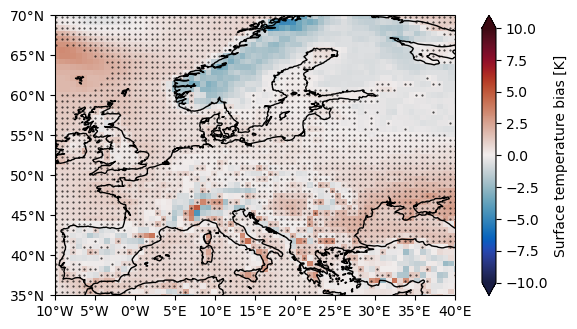

In [50]:
plotdir="/usr/people/muntjewe/papers/data_paper/"

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(2, 1 )#, figure=fig,height_ratios=[2, 1])
#fig = plt.figure(figsize=(14,5))
#gs = gridspec.GridSpec(1, 2, figure=fig) #,width_ratios=[3, 1])
#cmap = cm.seismic 
cmap = cmo.balance

vmin1=-10
vmax1=10

#gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 3.2])



# ============================  fig 1

# ax1 = libplot.define_global_map(fig,sps=gs[0,0])
# cl = anom.plot.imshow(robust=True, ax=ax1, add_colorbar=True, extend='both',vmin=vmin1, vmax=vmax1, cmap=cmap) #, levels=21)
# #_ = ax1.scatter(lons[nosig_area][::12], lats[nosig_area][::12], marker = '.', s = 0.5, c = 'k', alpha = 0.6, transform = myproj) # 
# cl.colorbar.set_label('Surface temperature bias [K]')

# #prc_corr.plot(ax=a1, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
# #_ = ax1.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

# ax1.set_title('')
# ax1.set_title('(a) Global annual-mean bias w.r.t. ERA5 1990-2019 (pval < 0.01) ',loc='left',fontsize=12)

# ============================  fig 2

#ax2 = libplot.define_europe_map(fig,sps=gs[1,0])

extent=[-10, 40, 35, 70]
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

ax2 = fig.add_subplot(gs[1,0], projection=myproj)
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_xticks(np.arange(-180, 181, 5), crs=myproj)
ax2.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])



cr = anom.plot.imshow(robust=True, ax=ax2, transform=myproj,  extend='both', add_colorbar=True,vmin=vmin1, vmax=vmax1, cmap=cmap ) #, levels=21)
_ = ax2.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)

cr.colorbar.set_label('Surface temperature bias [K]')
ax2.set_ylabel('')
ax2.set_xlabel('')

ax2.set_title('')
#ax2.set_title('(b) Europe annual-mean bias w.r.t. ERA5 1990-2019 (pval < 0.01)  ',loc='left',fontsize=12)




plt.tight_layout()

#plt.savefig(plotdir+"fig_datadescr_biasERA_1990-2019.png")

#plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

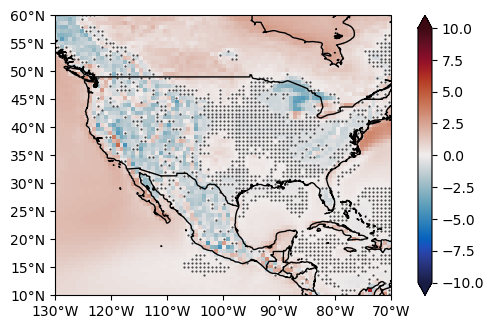

In [68]:
plotdir="/usr/people/muntjewe/papers/data_paper/"

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(2, 1 )#, figure=fig,height_ratios=[2, 1])
#fig = plt.figure(figsize=(14,5))
#gs = gridspec.GridSpec(1, 2, figure=fig) #,width_ratios=[3, 1])
#cmap = cm.seismic 
cmap = cmo.balance

vmin1=-10
vmax1=10

#gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 3.2])


#ax2 = libplot.define_europe_map(fig,sps=gs[1,0])

extent=[-130, -70, 10, 60]
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()

ax2 = fig.add_subplot(gs[1,0], projection=myproj)
# plt.imshow(Z, vmin = 0., vmax = 3., cmap=plt.cm.coolwarm, origin='lower', extent=[X.min(), X.max(), Y.min(), Y.max()])

c2 = anom.plot.imshow(ax=ax2, transform=myproj, extend='both', vmin=vmin1, vmax=vmax1, cmap=cmap ) #, levels=21)
_ = ax2.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)


ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax2.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])




# cr = anom.plot.imshow(robust=True, ax=ax2, transform=myproj,  vmin=vmin1, vmax=vmax1, cmap=cmap ) #, levels=21)
# _ = ax2.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)

#cr.colorbar.set_label('Surface temperature bias [K]')
ax2.set_ylabel('')
ax2.set_xlabel('')

ax2.set_title('')

#ax2.set_title('(b) Europe annual-mean bias w.r.t. ERA5 1990-2019 (pval < 0.01)  ',loc='left',fontsize=12)



plt.colorbar()
plt.tight_layout()

In [22]:
import matplotlib.gridspec as gridspec

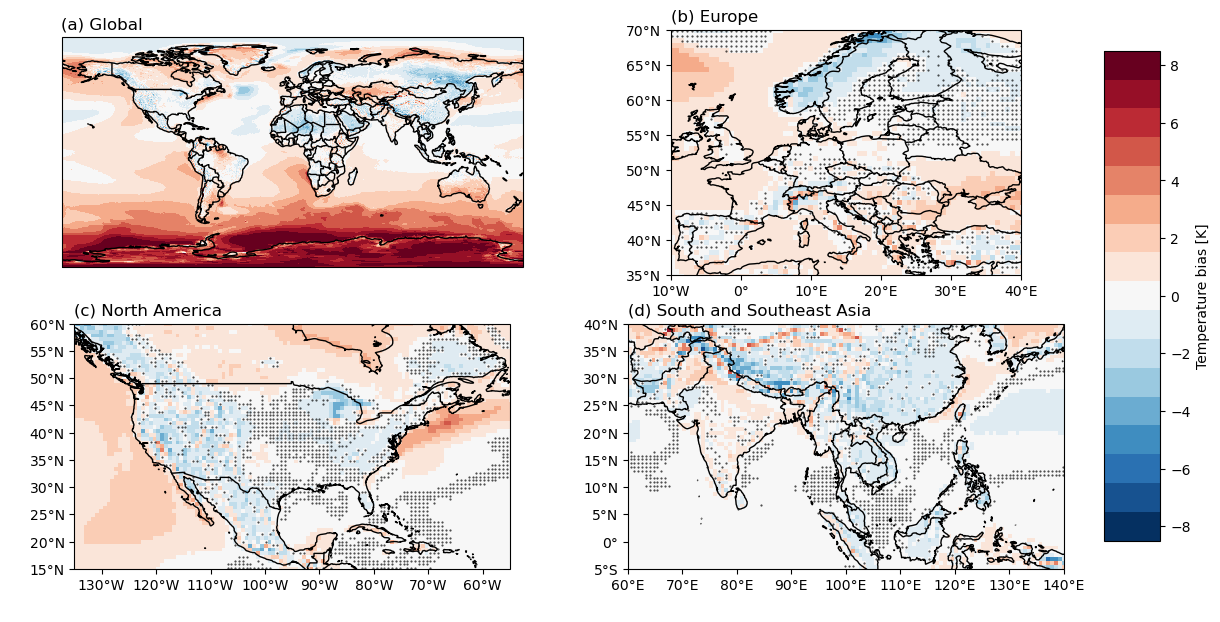

<Figure size 640x480 with 0 Axes>

In [23]:

fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(2, 2)
#cmap = cmo.balance
#cmap = cm.get_cmap('cmo.balance', 17) 
cmap = cm.get_cmap('RdBu_r', 17) 

vmin1=-8.5
vmax1=8.5


lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()



extent=[-180, -180, -90, 90]
ax1 = fig.add_subplot(gs[0,0], projection=myproj)
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_ylabel('')
ax1.set_xlabel('')
im1 = anom.plot.imshow(ax=ax1, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
ax1.set_title('(a) Global',loc='left',fontsize=12)


extent=[-10, 40, 35, 70]
ax2 = fig.add_subplot(gs[0,1], projection=myproj)
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax2.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])
im1 = anom.plot.imshow(ax=ax2, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
_ = ax2.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_title('(b) Europe ',loc='left',fontsize=12)

extent=[-135, -55, 15, 60]
ax3 = fig.add_subplot(gs[1,0], projection=myproj)
ax3.set_extent(extent, crs=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax3.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_xlim(extent[0], extent[1])
ax3.set_ylim(extent[2], extent[3])
im1 = anom.plot.imshow(ax=ax3, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
_ = ax3.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)
ax3.set_ylabel(' ')
ax3.set_xlabel(' ')
ax3.set_title('(c) North America ',loc='left',fontsize=12)

extent=[60, 140, -5, 40]
ax4 = fig.add_subplot(gs[1,1], projection=myproj)
ax4.set_extent(extent, crs=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_xticks(np.arange(-180, 181, 10), crs=myproj)
ax4.set_yticks(np.arange(-90, 91, 5), crs=myproj)
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.set_xlim(extent[0], extent[1])
ax4.set_ylim(extent[2], extent[3])
im1 = anom.plot.imshow(ax=ax4, vmin=vmin1, vmax=vmax1, cmap=cmap, add_colorbar=False)
_ = ax4.scatter(lons[nosig_area], lats[nosig_area], marker = '.', s = 1, c = 'k', alpha = 0.8, transform = myproj)
ax4.set_ylabel('')
ax4.set_xlabel('')
ax4.set_title('(d) South and Southeast Asia ',loc='left',fontsize=12)



# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.04, 0.7])
#cbar.set_label('your label here')
fig.colorbar(im1, cax=cbar_ax, label='Temperature bias [K]')



plt.show()
plt.tight_layout()

In [70]:
anom_ts_season = anom_ts.groupby('time.season').mean()

In [72]:
libtimeseries.boxmean(anom_ts_season)

<xarray.DataArray (season: 1)>
dask.array<truediv, shape=(1,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * season   (season) object 'DJF'

In [73]:
libtimeseries.boxmean(anom_ts_season).values()

TypeError: 'numpy.ndarray' object is not callable

In [74]:
anom_ts

<xarray.DataArray (time: 7, lat: 256, lon: 512)>
dask.array<sub, shape=(7, 256, 512), dtype=float32, chunksize=(7, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-02-15 2002-02-15 ... 2009-02-15
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 -180.0 -179.3 -178.6 -177.9 ... 177.9 178.6 179.3
    height   float64 2.0

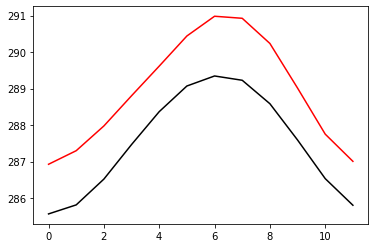

In [113]:
plt.plot(libtimeseries.boxmean(tas.mean(dim='ens').groupby('time.month').mean(dim='time')),color='r')
plt.plot(libtimeseries.boxmean(tasERA.groupby('time.month').mean(dim='time')),color='k')

In [ ]:

print('Now we are computing some statistics of the tas bias')

ECE_seasons = tas.mean(dim='ens').groupby('time.season').mean(dim='time')
ECE_seasons_std = tas.std(dim='ens').groupby('time.season').mean(dim='time')

ERA_seasons = tasERA.groupby('time.season').mean(dim='time')
anom_season = ECE_seasons - ERA_seasons


print('Global biases')
## Explicit conversion by wrapping a DataArray with np.asarray also works. I need to do this to access values. See https://docs.xarray.dev/en/v0.9.3/dask.html
glbias = (np.asarray(libtimeseries.boxmean(anom_season))) 
glstd = (np.asarray(libtimeseries.boxmean(ECE_seasons_std))) 
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(glbias[0],2))+' (ens stddev: '+str(np.round(glstd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(glbias[1],2))+' (ens stddev: '+str(np.round(glstd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(glbias[2],2))+' (ens stddev: '+str(np.round(glstd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(glbias[3],2))+' (ens stddev: '+str(np.round(glstd[3],2))+')')
print('ANN = '+str(np.round(glbias.mean(),2))+' (ens stddev: '+str(np.round(glstd.mean(),2))+')')
print('')
nhbias = (np.asarray(libtimeseries.NHboxmean(anom_season))) 
nhstd = (np.asarray(libtimeseries.NHboxmean(ECE_seasons_std))) 
print('Northern Hemisphere biases')
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(nhbias[0],2))+' (ens stddev: '+str(np.round(nhstd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(nhbias[1],2))+' (ens stddev: '+str(np.round(nhstd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(nhbias[2],2))+' (ens stddev: '+str(np.round(nhstd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(nhbias[3],2))+' (ens stddev: '+str(np.round(nhstd[3],2))+')')
print('== ANN: '+str(np.round(nhbias.mean(),2))+' (ens stddev: '+str(np.round(nhbias.mean(),2))+')')
print('')
eubias = (np.asarray(libtimeseries.EUboxmean(anom_season))) 
eustd = (np.asarray(libtimeseries.EUboxmean(ECE_seasons_std))) 
print('Europe biases')
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(eubias[0],2))+' (ens stddev: '+str(np.round(eustd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(eubias[1],2))+' (ens stddev: '+str(np.round(eustd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(eubias[2],2))+' (ens stddev: '+str(np.round(eustd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(eubias[3],2))+' (ens stddev: '+str(np.round(eustd[3],2))+')')
print('== ANN: '+str(np.round(eubias.mean(),2))+' (ens stddev: '+str(np.round(eubias.mean(),2))+')')

NAbias = (np.asarray(libtimeseries.NAboxmean(anom_season))) 
NAstd = (np.asarray(libtimeseries.NAboxmean(ECE_seasons_std))) 
print('North America biases')
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(NAbias[0],2))+' (ens stddev: '+str(np.round(NAstd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(NAbias[1],2))+' (ens stddev: '+str(np.round(NAstd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(NAbias[2],2))+' (ens stddev: '+str(np.round(NAstd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(NAbias[3],2))+' (ens stddev: '+str(np.round(NAstd[3],2))+')')
print('== ANN: '+str(np.round(NAbias.mean(),2))+' (ens stddev: '+str(np.round(NAbias.mean(),2))+')')

SAbias = (np.asarray(libtimeseries.SAboxmean(anom_season))) 
SAstd = (np.asarray(libtimeseries.SAboxmean(ECE_seasons_std))) 
print('South and Southeast Asia biases')
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(SAbias[0],2))+' (ens stddev: '+str(np.round(SAstd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(SAbias[1],2))+' (ens stddev: '+str(np.round(SAstd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(SAbias[2],2))+' (ens stddev: '+str(np.round(SAstd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(SAbias[3],2))+' (ens stddev: '+str(np.round(SAstd[3],2))+')')
print('== ANN: '+str(np.round(SAbias.mean(),2))+' (ens stddev: '+str(np.round(SAbias.mean(),2))+')')

Now we are computing some statistics of the tas bias
Global biases


In [127]:
print('Now we are computing some statistics of the tas bias')

ECE_seasons = tas.mean(dim='ens').groupby('time.season').mean(dim='time')
ECE_seasons_std = tas.std(dim='ens').groupby('time.season').mean(dim='time')

ERA_seasons = tasERA.groupby('time.season').mean(dim='time')
anom_season = ECE_seasons - ERA_seasons


print('Global biases')
## Explicit conversion by wrapping a DataArray with np.asarray also works. I need to do this to access values. See https://docs.xarray.dev/en/v0.9.3/dask.html
glbias = (np.asarray(libtimeseries.boxmean(anom_season))) 
glstd = (np.asarray(libtimeseries.boxmean(ECE_seasons_std))) 
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(glbias[0],2))+' (ens stddev: '+str(np.round(glstd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(glbias[1],2))+' (ens stddev: '+str(np.round(glstd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(glbias[2],2))+' (ens stddev: '+str(np.round(glstd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(glbias[3],2))+' (ens stddev: '+str(np.round(glstd[3],2))+')')
print('ANN = '+str(np.round(glbias.mean(),2))+' (ens stddev: '+str(np.round(glstd.mean(),2))+')')
print('')
nhbias = (np.asarray(libtimeseries.NHboxmean(anom_season))) 
nhstd = (np.asarray(libtimeseries.NHboxmean(ECE_seasons_std))) 
print('Northern Hemisphere biases')
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(nhbias[0],2))+' (ens stddev: '+str(np.round(nhstd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(nhbias[1],2))+' (ens stddev: '+str(np.round(nhstd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(nhbias[2],2))+' (ens stddev: '+str(np.round(nhstd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(nhbias[3],2))+' (ens stddev: '+str(np.round(nhstd[3],2))+')')
print('== ANN: '+str(np.round(nhbias.mean(),2))+' (ens stddev: '+str(np.round(nhbias.mean(),2))+')')
print('')
eubias = (np.asarray(libtimeseries.EUboxmean(anom_season))) 
eustd = (np.asarray(libtimeseries.EUboxmean(ECE_seasons_std))) 
print('Europe biases')
print(str(libtimeseries.boxmean(anom_season).season[0].values)+' = '+str(np.round(eubias[0],2))+' (ens stddev: '+str(np.round(eustd[0],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[1].values)+' = '+str(np.round(eubias[1],2))+' (ens stddev: '+str(np.round(eustd[1],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[2].values)+' = '+str(np.round(eubias[2],2))+' (ens stddev: '+str(np.round(eustd[2],2))+')')
print(str(libtimeseries.boxmean(anom_season).season[3].values)+' = '+str(np.round(eubias[3],2))+' (ens stddev: '+str(np.round(eustd[3],2))+')')
print('== ANN: '+str(np.round(eubias.mean(),2))+' (ens stddev: '+str(np.round(eubias.mean(),2))+')')

Now we are computing some statistics of the tas bias
Global biases
DJF = 1.24 (ens stddev: 1.1)
JJA = 1.45 (ens stddev: 0.88)
MAM = 1.22 (ens stddev: 1.0)
SON = 1.36 (ens stddev: 0.93)
ANN = 1.32 (ens stddev: 0.97)

Northern Hemisphere biases
DJF = 0.22 (ens stddev: 1.46)
JJA = 0.44 (ens stddev: 0.97)
MAM = -0.26 (ens stddev: 1.24)
SON = 0.64 (ens stddev: 1.12)
== ANN: 0.26 (ens stddev: 0.26)

Europe biases
DJF = -0.1 (ens stddev: 1.99)
JJA = 0.91 (ens stddev: 1.38)
MAM = -0.06 (ens stddev: 1.62)
SON = 0.76 (ens stddev: 1.44)
== ANN: 0.38 (ens stddev: 0.38)
